In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../../thesis-style.mpl")

In [2]:
    ssp_legend = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 8,
            }

In [3]:
import thesis
def thesisify(f, height=1):
    from matplotlib import rc, font_manager
    lato = {'family': 'Lato',
            'color':  'black',
            'weight': 'light',
            'size': 10,
            }
    ssp_ticks = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 6,
            }
    ssp_legend = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 8,
            }
    ticks_font = font_manager.FontProperties(**ssp_ticks)
    # make the figure look the correct size
    f.set_figwidth(thesis.figwidth)
    f.set_figheight(height * thesis.figheight)
    # individual axis manipulations
    for ax in f.axes:
        for label in ax.get_xticklabels():
            label.set_fontproperties(ticks_font)
        ax.set_xlabel(ax.get_xlabel(), fontdict=lato)  
        ax.xaxis.get_offset_text().set_fontproperties(ticks_font)
        for label in ax.get_yticklabels():
            label.set_fontproperties(ticks_font)
        ax.set_ylabel(ax.get_ylabel(), fontdict=lato) 
        ax.yaxis.get_offset_text().set_fontproperties(ticks_font)
        
        if len(ax.get_ygridlines()) > 0:
            ax.grid(which="both", color='#348ABD', alpha=0.4, lw=0.3,)
        
    f.tight_layout()
    return f

In [4]:
import numpy as np

In [5]:
import elk.catalogue

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

In [7]:
data = catalogue.waveforms[0].timeseries(total_mass=60, sample_rate = 4096, flow=90)

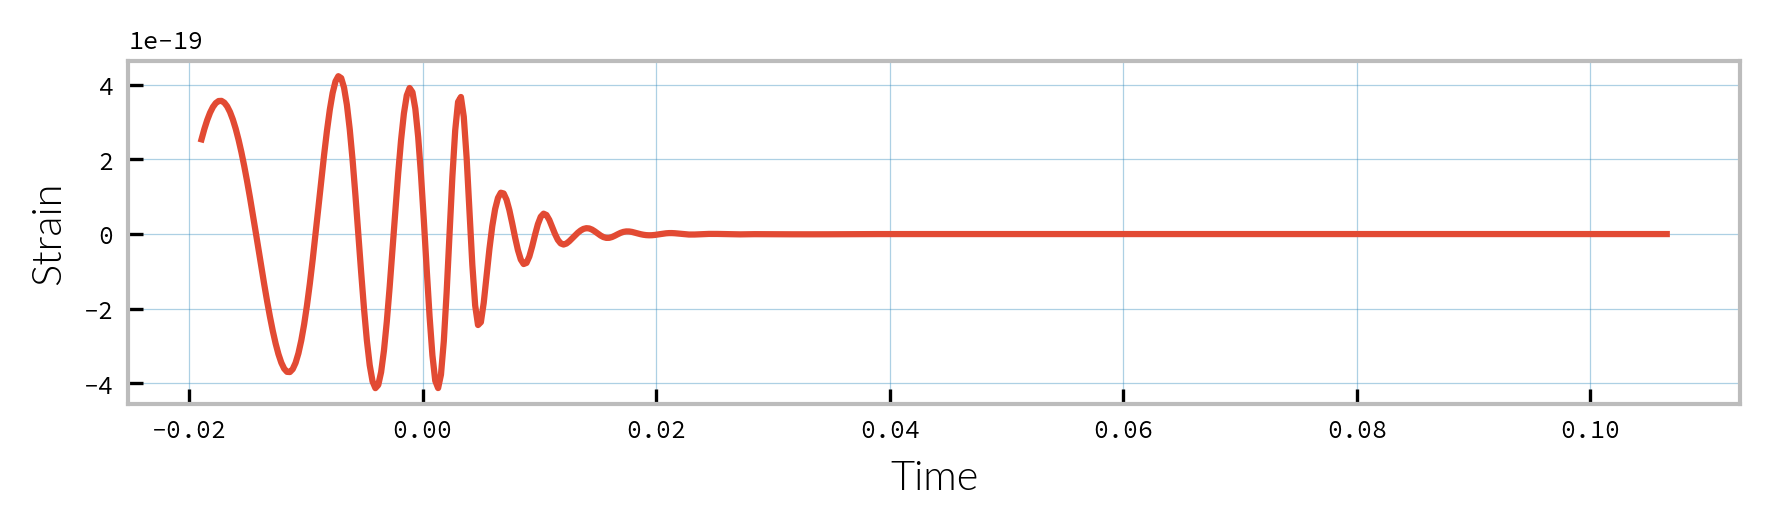

In [8]:
f, ax = plt.subplots(1,1, dpi=300);
ax.plot(data[0].times, data[0].data);
ax.set_ylabel("Strain");
ax.set_xlabel("Time");

thesisify(f, height=0.5);

In [9]:
Y = data[0].data *1e19
X = np.atleast_2d(data[0].times)

In [10]:
import pymc3 as pm

In [11]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    ls_t =  pm.Uniform("time", 0, .01) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    #ls_q = pm.Uniform("metric_q", 0,1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.ExpQuad(1, ls=ls_t) #*pm.gp.cov.ExpQuad(1, active_dims=[2], ls=ls_q) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=X.T, y=Y, noise=0.0001, is_observed=True)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '18239' (I am process '4752')
/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [12]:
with model:
    mp = pm.find_MAP()

logp = 2,234.6, ||grad|| = 0.64295: 100%|██████████| 120/120 [00:52<00:00,  2.30it/s]      


In [13]:
mp

{'amplitude_time': array(8.),
 'amplitude_time_interval__': array(0.),
 'sigma': array(0.00125),
 'time': array(0.00100702),
 'time_interval__': array(-2.1894449)}

In [14]:
t_new = np.linspace(-0.02,0.1, 500)[::,None]
#x_new = np.dstack([t_new, q_new])[0]
#print(x_new[0])
mp['time'] = np.array(0.001)
#mp['time_interval__'] = np.array(.001)
mu, var = gp.predict(t_new, point=mp, diag=True)
sd = np.sqrt(var)

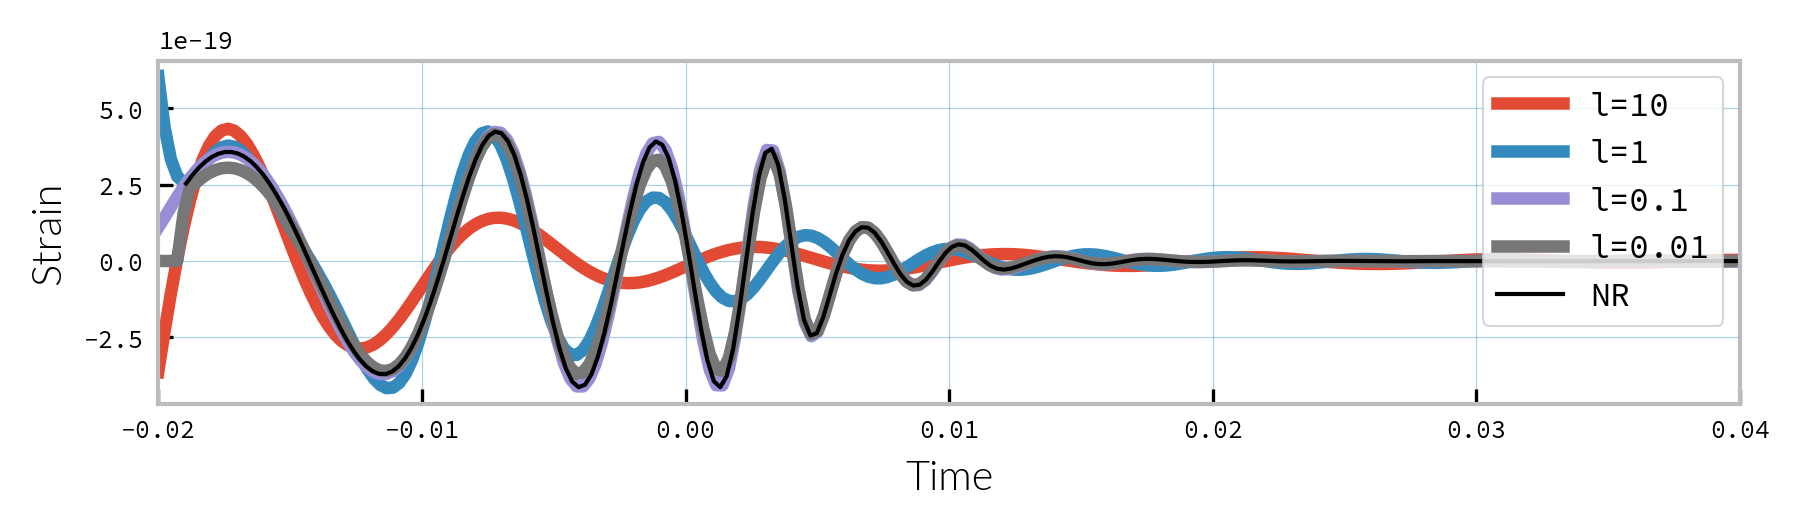

In [19]:
f, ax = plt.subplots(1,1, dpi=300);

ax.set_ylabel("Strain");
ax.set_xlabel("Time");

for l in [10, 1, 0.1, 0.01]:

    mp['time'] = np.array(l)
    mp['time_interval__'] = np.array(np.log(mp['time']))
    mu, var = gp.predict(t_new, point=mp, diag=True)
    sd = np.sqrt(var)
    ax.plot(t_new, mu/1e19, label="l={}".format(l), lw=3)

    

ax.set_xlim([-0.02, 0.04])
    
    
ax.plot(data[0].times, data[0].data, label="NR", color ='k', lw=1);
ax.legend(prop=ssp_legend, loc="upper right")

thesisify(f, height=0.5);